# Auto-Tagging System
* Auto-tagging questions (a.k.a **multi-label classification**) involves assigning multiple relevant tags or labels to a given question or text. 

* Best way to handle the auto-tagging of questions depends on the complexity and scale of the dataset:
    * For **smaller datasets** or simpler use cases: **TF-IDF with Multi-label Logistic Regression**
    * For more complex and **larger datasets**: **Transformer models** (BERT, RoBERTa etc.) fine-tuned for multi-label classification

In [1]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import spacy
from bs4 import BeautifulSoup
from tqdm import tqdm

import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import evaluate

import warnings

# Load the spacy English model
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

## Load and Explore Data 

In [3]:
df = pd.read_csv('/kaggle/input/500k-stackoverflow-questions/questions.csv')
df.head()

,date,links,questions,tags,time
0,2021-03-24 11:01:18.812726,/questions/66775243/how-to-display-jalali-date...,How to display jalali date in to view in Codei...,"php,codeigniter,date,gregorian-calendar",2 mins ago
1,2021-03-24 11:01:18.814679,/questions/66775242/automate-creating-of-sales...,Automate creating of sales order in Zoho Books,"python-3.x,zohobooks",2 mins ago
2,2021-03-24 11:01:18.817728,/questions/66775240/java-jar-error-for-spring-...,java jar error for spring boot applicaton,"java,spring,spring-boot",3 mins ago
3,2021-03-24 11:01:18.818696,/questions/66775238/not-able-to-run-unfoldingm...,Not able to run UnfoldingMap library,"java,eclipse,dictionary,core,unfoldingmap",3 mins ago
4,2021-03-24 11:01:18.820720,/questions/66775237/serverless-graphql-lambda-...,Serverless Graphql Lambda hard to understand t...,"typescript,webpack,error-handling,graphql,serv...",3 mins ago


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529804 entries, 0 to 529803
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       529804 non-null  object
 1   links      529804 non-null  object
 2   questions  529804 non-null  object
 3   tags       529804 non-null  object
 4   time       529804 non-null  object
dtypes: object(5)
memory usage: 20.2+ MB


In [5]:
df_sub = df.sample(frac=0.20, random_state=42).reset_index()
df_sub.drop(columns=['index'], inplace=True)
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105961 entries, 0 to 105960
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       105961 non-null  object
 1   links      105961 non-null  object
 2   questions  105961 non-null  object
 3   tags       105961 non-null  object
 4   time       105961 non-null  object
dtypes: object(5)
memory usage: 4.0+ MB


In [6]:
df_sub.columns.tolist()

['date', 'links', 'questions', 'tags', 'time']

In [7]:
df_sub.drop(columns=['date', 'links', 'time'], inplace=True)
df_sub.head()

,questions,tags
0,How would I do a deep compare two maps in a un...,"java,junit,assertj"
1,Error trying to connect MongoDB with mongoose,"node.js,mongodb"
2,Avoid pagination limits for simple output - Sh...,"javascript,ajax,pagination,shopify,liquid"
3,Type Error: Cannot read the property of ID of ...,"javascript,node.js,discord,discord.js"
4,Is there way to acces every RecyclerViewHolder?,"android,android-studio,kotlin,mobile"


In [8]:
# add a column that includes tag list
df_sub['tag_list'] = df_sub['tags'].str.split(',')
df_sub.head()

,questions,tags,tag_list
0,How would I do a deep compare two maps in a un...,"java,junit,assertj","[java, junit, assertj]"
1,Error trying to connect MongoDB with mongoose,"node.js,mongodb","[node.js, mongodb]"
2,Avoid pagination limits for simple output - Sh...,"javascript,ajax,pagination,shopify,liquid","[javascript, ajax, pagination, shopify, liquid]"
3,Type Error: Cannot read the property of ID of ...,"javascript,node.js,discord,discord.js","[javascript, node.js, discord, discord.js]"
4,Is there way to acces every RecyclerViewHolder?,"android,android-studio,kotlin,mobile","[android, android-studio, kotlin, mobile]"


In [9]:
# get total number of tags
# get a sorted list (based on count) of tags
df_flattened = df_sub.explode('tag_list')['tag_list']
tag_counts = df_flattened.value_counts()
print(f"Total Tags: {len(df_flattened.unique().tolist())}")
print(f"Total Tags: {tag_counts}")

Total Tags: 19871
Total Tags: tag_list
python        16386
javascript    11498
java           6100
reactjs        5163
html           4510
              ...  
do-loops          1
java-heap         1
isis              1
qtserial          1
liclipse          1
Name: count, Length: 19871, dtype: int64


In [10]:
# filter the tags based upon count
# use a specific threshold to filter tags
threshold = 1000
valid_tags = tag_counts[tag_counts > threshold].index

def filter_tags(tags):
    return [tag if tag in valid_tags else None for tag in tags]

df_sub['filtered_tags'] = df_sub['tag_list'].apply(filter_tags)
df_sub.head()

,questions,tags,tag_list,filtered_tags
0,How would I do a deep compare two maps in a un...,"java,junit,assertj","[java, junit, assertj]","[java, None, None]"
1,Error trying to connect MongoDB with mongoose,"node.js,mongodb","[node.js, mongodb]","[node.js, mongodb]"
2,Avoid pagination limits for simple output - Sh...,"javascript,ajax,pagination,shopify,liquid","[javascript, ajax, pagination, shopify, liquid]","[javascript, None, None, None, None]"
3,Type Error: Cannot read the property of ID of ...,"javascript,node.js,discord,discord.js","[javascript, node.js, discord, discord.js]","[javascript, node.js, None, None]"
4,Is there way to acces every RecyclerViewHolder?,"android,android-studio,kotlin,mobile","[android, android-studio, kotlin, mobile]","[android, None, None, None]"


In [11]:
# remove none from filtered tags list
df_cleaned = df_sub[~df_sub['filtered_tags'].apply(lambda x: all(elem is None for elem in x))]
df_cleaned.reset_index(inplace=True)
df_cleaned.drop(columns=['index'], inplace=True)
df_cleaned['filtered_tags'] = df_cleaned['filtered_tags'].apply(lambda x: [elem for elem in x if elem is not None])
df_cleaned.head()

/tmp/ipykernel_30/331898683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=['index'], inplace=True)
/tmp/ipykernel_30/331898683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['filtered_tags'] = df_cleaned['filtered_tags'].apply(lambda x: [elem for elem in x if elem is not None])


,questions,tags,tag_list,filtered_tags
0,How would I do a deep compare two maps in a un...,"java,junit,assertj","[java, junit, assertj]",[java]
1,Error trying to connect MongoDB with mongoose,"node.js,mongodb","[node.js, mongodb]","[node.js, mongodb]"
2,Avoid pagination limits for simple output - Sh...,"javascript,ajax,pagination,shopify,liquid","[javascript, ajax, pagination, shopify, liquid]",[javascript]
3,Type Error: Cannot read the property of ID of ...,"javascript,node.js,discord,discord.js","[javascript, node.js, discord, discord.js]","[javascript, node.js]"
4,Is there way to acces every RecyclerViewHolder?,"android,android-studio,kotlin,mobile","[android, android-studio, kotlin, mobile]",[android]


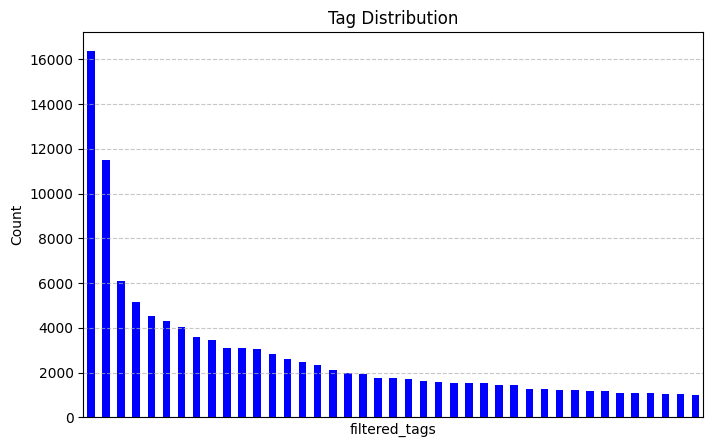

filtered_tags
python          16386
javascript      11498
java             6100
reactjs          5163
html             4510
c#               4305
android          4024
php              3611
node.js          3447
python-3.x       3097
r                3078
css              3060
c++              2841
pandas           2587
sql              2482
flutter          2341
angular          2103
django           1987
typescript       1938
mysql            1769
arrays           1740
swift            1714
c                1626
json             1572
ios              1545
laravel          1538
jquery           1531
react-native     1448
dataframe        1432
excel            1267
Name: count, dtype: int64

In [12]:
# keep only top_k_tags
top_k_tags = 30
fil_tags_count = df_cleaned.explode('filtered_tags')['filtered_tags'].value_counts()

plt.figure(figsize=(8, 5))
fil_tags_count.plot(kind='bar', color='blue')
plt.title('Tag Distribution')
plt.ylabel('Count')
plt.xticks([]) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

top_tags = fil_tags_count.head(top_k_tags)
top_tags

In [13]:
labels = top_tags.index.tolist()
print(f"Total Labels: {len(labels)}")
print(f"Labels: {labels}")

Total Labels: 30
Labels: ['python', 'javascript', 'java', 'reactjs', 'html', 'c#', 'android', 'php', 'node.js', 'python-3.x', 'r', 'css', 'c++', 'pandas', 'sql', 'flutter', 'angular', 'django', 'typescript', 'mysql', 'arrays', 'swift', 'c', 'json', 'ios', 'laravel', 'jquery', 'react-native', 'dataframe', 'excel']


## Preprocess Data

In [14]:
def preprocess_text(text):
    # 1. Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 2. Process text using spacy
    doc = nlp(text)
    
    # 3. Filter out stop words, punctuation, and lemmatize the tokens
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    # 4. Join tokens back into a clean string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [15]:
def preprocess_text(text):
    questions = text
    cleaned_questions = []

    # Batch processing
    for doc in tqdm(nlp.pipe(questions, batch_size=32), total=len(questions), desc='Processing questions'):
        cleaned_question = ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha])
        cleaned_questions.append(cleaned_question)
    
    return cleaned_questions

In [16]:
df_cleaned['cleaned_questions'] = preprocess_text(text=df_cleaned['questions'].tolist())
df_cleaned['cleaned_questions'].head()

Processing questions: 100%|██████████| 78768/78768 [01:19<00:00, 986.61it/s] 
/tmp/ipykernel_30/500641256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_questions'] = preprocess_text(text=df_cleaned['questions'].tolist())


0                 deep compare map unit test duplicate
1                   error try connect mongodb mongoose
2    avoid pagination limit simple output shopify l...
3                type error read property id undefined
4                          way acce recyclerviewholder
Name: cleaned_questions, dtype: object

In [17]:
df_f = df_cleaned.drop(columns=['questions', 'tags', 'tag_list'])
df_f.rename(columns={'cleaned_questions': 'questions', 'filtered_tags': 'tags'}, inplace=True)
df_f = df_f[['questions', 'tags']]

## Micro and Macro F1 Scores

* **Macro F1 Score**
    * **Use Case**: When all classes are equally important, regardless of how frequent or infrequent they are.
    * **Definition**: The macro F1 score calculates the F1 score for each class independently and then takes the average. This gives equal weight to each class, regardless of its support (how many instances it has).
* **Micro F1 Score**
    * **Use Case**: When the overall accuracy across all instances is important, and you want to maximize correct predictions without giving special importance to any class.
    * **Definition**: The micro F1 score aggregates the contributions of all classes to calculate the F1 score. It computes the metrics globally by counting the total true positives, false negatives, and false positives across all classes.

## Transformer Model

### Train Test Split

In [18]:
# its better to hold out a set for validation and test sets
# but for simplicity, only test set is being used for validation

train_df, test_df = train_test_split(df_f, test_size=0.1)

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.remove_columns('__index_level_0__')
test_ds = test_ds.remove_columns('__index_level_0__')
train_ds

Dataset({
    features: ['questions', 'tags'],
    num_rows: 70891
})

In [19]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}

In [20]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Tokenizer

In [21]:
def tokenize(examples):
    return tokenizer(examples['questions'], 
                     padding='max_length', 
                     truncation=True, 
                     max_length=128)

In [22]:
train_ds = train_ds.map(tokenize, batched=True, batch_size=64)
test_ds = test_ds.map(tokenize, batched=True, batch_size=64)

Map:   0%|          | 0/70891 [00:00<?, ? examples/s]

Map:   0%|          | 0/7877 [00:00<?, ? examples/s]

In [23]:
train_ds

Dataset({
    features: ['questions', 'tags', 'input_ids', 'attention_mask'],
    num_rows: 70891
})

In [24]:
def convert_labels_to_binary(labels_batch):
    """Convert a list of labels to a binary vector."""
    return [[1 if label in b_labels else 0 for label in labels] for b_labels in labels_batch]

In [25]:
train_ds['tags'][2]

['jquery']

In [26]:
train_ds = train_ds.map(lambda x: {'labels': convert_labels_to_binary(x['tags'])}, batched=True)
train_ds = train_ds.map(lambda x: {'labels': torch.tensor(x['labels'])}, batched=True)

test_ds = test_ds.map(lambda x: {'labels': convert_labels_to_binary(x['tags'])}, batched=True)
test_ds = test_ds.map(lambda x: {'labels': torch.tensor(x['labels'])}, batched=True)


Map:   0%|          | 0/70891 [00:00<?, ? examples/s]

Map:   0%|          | 0/70891 [00:00<?, ? examples/s]

Map:   0%|          | 0/7877 [00:00<?, ? examples/s]

Map:   0%|          | 0/7877 [00:00<?, ? examples/s]

In [27]:
train_ds = train_ds.remove_columns(['tags', 'questions'])
test_ds = test_ds.remove_columns(['tags', 'questions'])

In [28]:
train_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 70891
})

### Evlauation Metrics

In [29]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    logits_tensor = torch.tensor(logits)
    
    predictions = (torch.sigmoid(logits_tensor) > 0.5).to(torch.int32)
    references = torch.tensor(labels, dtype=torch.int32)
    
    predictions_flat = predictions.flatten()
    references_flat = references.flatten()

    inputs = {
        'predictions': predictions_flat,
        'references': references_flat
    }

    accuracy = accuracy_metric.compute(**inputs)
    f1 = f1_metric.compute(**inputs, average='macro')
    
    return {"accuracy": accuracy, "f1": f1}


### Focal Loss (for imbalanced datasets)

In [30]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, labels):
        
        BCE_loss = nn.BCEWithLogitsLoss()(logits, labels)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()


In [31]:
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [32]:
train_ds['input_ids'][0]

tensor([ 101, 6140, 2193, 2240, 6140, 3643,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

### Transformer Model for Sequence Classification

In [33]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, 
                                                            num_labels=len(labels), 
                                                            problem_type="multi_label_classification",
                                                            label2id=label2id,
                                                            id2label=id2label)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Custom Trainer

In [34]:
class MultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        
        labels = inputs.pop("labels")
        if labels is not None and labels.dtype != torch.float32:
            labels = labels.float()
        
        outputs = model(**inputs)
        logits = outputs.logits
        
        if logits.dtype != torch.float32:
            logits = logits.float()

        if labels.dtype != torch.float32 and labels.dtype != torch.int64:
            labels = labels.float() 

        loss_fn = FocalLoss()
        loss = loss_fn(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [35]:
batch_size = 64
logging_steps = 30
epochs = 3

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=5e-5,
#                                   warmup_steps=50, # warmup
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  report_to="none",
                                  save_strategy="no", # do not save model
                                  save_steps=100_000,
                                  push_to_hub=False,
                                  log_level="error",
                                  remove_unused_columns=False)


In [36]:
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")
warnings.filterwarnings("ignore", category=UserWarning, module="torch")


trainer = MultiLabelTrainer(model=model, 
                            args=training_args,
                            compute_metrics=compute_metrics,
                            train_dataset=train_ds,
                            eval_dataset=test_ds,
                            tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.001100,0.000972,{'accuracy': 0.9688079217976387},{'f1': 0.7372035493919447}
2,0.000600,0.000644,{'accuracy': 0.9717870593711649},{'f1': 0.7909421706509971}
3,0.000600,0.000580,{'accuracy': 0.9728153696415726},{'f1': 0.7979844966359475}


In [37]:
trainer.evaluate()


{'eval_loss': 0.0005802327650599182,
 'eval_accuracy': {'accuracy': 0.9728153696415726},
 'eval_f1': {'f1': 0.7979844966359475},
 'eval_runtime': 20.034,
 'eval_samples_per_second': 393.182,
 'eval_steps_per_second': 6.189,
 'epoch': 3.0}

### Find Best Threshold

In [38]:
def find_best_threshold(y_true, 
                        y_pred_probs, 
                        id2label=id2label, 
                        thresholds=[round(x, 2) for x in np.arange(0.5, 0.95 + 0.25, 0.25)]):
    best_f1 = 0.0
    best_threshold = 0.0
    best_f1_scores = {}

    for threshold in tqdm(thresholds):
        
        y_pred = (y_pred_probs >= threshold).astype(int)
        f1_per_label = f1_score(y_true, y_pred, average=None)
        avg_f1 = np.mean(f1_per_label)

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_threshold = threshold

    return best_threshold, best_f1

In [39]:
predictions_output = trainer.predict(train_ds)
y_true = predictions_output.label_ids
y_pred_probs = 1 / (1 + np.exp(-predictions_output.predictions))  # Apply sigmoid to logits

best_threshold, best_f1 = find_best_threshold(y_true.flatten(), y_pred_probs.flatten())
print(f"Best Threshold: {best_threshold}")
print(f"Best f1 Score: {best_f1}")

100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

Best Threshold: 0.5
Best f1 Score: 0.8173034158162162


### Predictions

In [40]:
def predict_with_threshold(sample_df, threshold, id2label=id2label):
    texts = sample_df['questions'].tolist()
    true_tags = sample_df['tags'].tolist()
    
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs.to(model.device)
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.sigmoid(logits)
    
    final_predictions = (predictions > torch.tensor(threshold)).int()
    
    pred_tags = []
    for pred in final_predictions:
        indices_where_one = np.where(pred.detach().cpu().numpy() == 1)[0]
        corresponding_tags = 'None'
        if len(indices_where_one) != 0:
            corresponding_tags = [id2label[i] for i in indices_where_one]
        pred_tags.append(corresponding_tags)
    sample_df['pred_tags'] = pred_tags
    return sample_df

In [41]:
sample_df = test_df.sample(30)

df_pred = predict_with_threshold(sample_df, best_threshold)
df_pred

,questions,tags,pred_tags
9963,locate value center palette world map,[r],[javascript]
37244,shape outisde property work intend transform g...,[css],[javascript]
13917,difference vs,[javascript],None
17958,mutex lock fail invalid argument autoreleasepool,[swift],None
55545,custom application class upgrade android embed,"[android, flutter]",[android]
979,accurate power number extraction root duplicate,[javascript],[python]
73220,vba function date text,[excel],[excel]
51871,merge multiple dataframe r simple dataframe du...,[r],[r]
67323,multidimensional array strtok,[c],None
71565,load webpage inside div html,[html],"[javascript, html]"
